# Report03 - 服装分类

* 姓名 李晨
* 学号 2018202069


## 任务简介

1. 任务类型   
多分类问题
2. 任务背景   
FashionMNIST 是一个替代 MNIST 手写数字集的图像数据集。 它是由 Zalando（一家德国的时尚科技公司）旗下的研究部门提供。其涵盖了来自 10 种类别的共 7 万个不同商品的正面图片。

3. 数据格式
FashionMNIST 的大小、格式和训练集/测试集划分与原始的 MNIST 完全一致。60000/10000 的训练测试数据划分，28x28 的灰度图片。
每个示例的高度为28个像素，宽度为28个像素，总共为784个像素。 每个像素具有与其相关联的单个像素值，指示该像素的亮度或暗度，较高的数字意味着较暗。 该像素值是0到255之间的整数。

|T-short/top| Trouser|Pullover|Dress|Coat|Sandal|Shirt|Sneaker|Bag|Ankle boot|
|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|
|0|1|2|3|4|5|6|7|8|9|


| / | Images_shape | Labels_shape | 
|:-:|:-:|:-:|
|train data|(10000, 784)|(10000,)|
|test data |(60000, 784)|(60000,)|


In [1]:
import os.path as path
import numpy as np

# 读取训练数据与展示
def loadData(f):
    f = path.join('fashion-mnist', f + '.npy')
    matrix = np.load(f)
    return matrix

trainImages, trainLabels = loadData('train-images'), loadData('train-labels')
testImages, testLabels = loadData('t10k-images'), loadData('t10k-labels')

print(f'[train data] : Images_shape = {trainImages.shape}, Labels_shape = {trainLabels.shape}')
print(f'[test  data] : Images_shape = {testImages.shape}, Labels_shape = {testLabels.shape}')

[train data] : Images_shape = (10000, 784), Labels_shape = (10000,)
[test  data] : Images_shape = (60000, 784), Labels_shape = (60000,)


## 解决途径


服装分类是一个多分类问题，搭建`全连接网络模型`实现分类和将训练数据处理后使用`卷积神经网络`都可以实现这样的分类功能，首先我们搭建全联接网络。
### 全连接网络（FCN）

In [2]:
import torch
from torch import nn
from torch import optim
from torch.autograd import Variable
import torch.nn.functional as F

1. 数据处理   
将读入的数据转化成torch使用的tensor类型；同时对测试数据进行分批，每一batch的测试数据与训练数据大小相同，防止出现内存溢出。

In [3]:
trainImages = torch.from_numpy(trainImages).float()
trainLabels = torch.from_numpy(trainLabels).long()

testEpoches = []
epochLen, dataLen = trainImages.shape[0], testImages.shape[0]
for i in range(0, dataLen, epochLen):
    start, end = i, min(i + epochLen, dataLen)
    testEpoches.append((
        torch.from_numpy(testImages[start:end]).float(),
        testLabels[start:end]
    ))

2. 定义全连接网络模块(FCN)   
这个简单的全连接网络需要传递进去的参数有：输入的维度，每个隐藏层的维度，以及输出层的维度。在这个模型中，我们使用`nn.ELU()`激活函数来增加网络的非线性，使用`nn.Sequential()`来将网络的层组合在一起作为`self.layer`；网络的最后一层`输出层`不能添加激活函数；使用`nn.BatchNormld()`函数来加快收敛的速度，同样使用`nn.Sequential()`来将`nn.BatchNormld()`组合在网络层中。批标准化一般放在全连接层的后面，非线性层激活函数的前面。    
`forward()`函数是前向传播函数。

In [4]:
class myFCNModule(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim):
        super().__init__()
        i, self.layer = 1, nn.Sequential()
        for h_dim in hidden_dim:
            self.layer.add_module('layer_{}'.format(i),
                                  # 线性模块
                                  nn.Sequential(nn.Linear(in_dim, h_dim), 
                                  # 批归一化
                                  nn.BatchNorm1d(h_dim),
                                  # ELU增加非线性
                                  nn.ELU(True)))
            i, in_dim = i + 1, h_dim
        self.layer.add_module('layer_{}'.format(i), nn.Sequential(nn.Linear(in_dim, out_dim)))
        self.layerNum = i
        
    def forward(self, x):
        x = self.layer(x)
        x = F.log_softmax(x, dim=1)
        return x

3. 导入网络并进行待以损失函数及优化方法  
因为输入的图片大小为`28*28`，所以输入维度是`28*28`，然后定义两个隐藏层分别是512和256，输出维度必须是10，因为这是一个10分类问题。  
损失函数定义为最常见的损失交叉墒函数，使用随机梯度下降来优化损失函数。

In [5]:
# 超参数（Hyperparameters）
learning_rate = 1e-2

myFCN = myFCNModule(784, [512, 256], 10)
if torch.cuda.is_available():
    myFCN = myFCN.cuda()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(myFCN.parameters(), lr = learning_rate)

4. 定义训练过程和测试过程
定义训练参数`numEpoches, printStep = 2000, 100`

In [6]:
def train(trainImages, trainLabels):
    myFCN.train()
    inputs, labels = Variable(trainImages), Variable(trainLabels)
    if torch.cuda.is_available():
        inputs, targets = inputs.cuda(), targets.cuda()
    outputs = myFCN(inputs)
    loss = criterion(outputs, labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
def test(test_inputs, outVector=False):
    myFCN.eval()
    inputs = Variable(test_inputs)
    if torch.cuda.is_available():
        inputs = inputs.cuda()
    outputs = myFCN(inputs)
    if outVector:
        return outputs
    _, predict = torch.max(outputs.data, 1)
    return predict

numEpoches, printStep = 2000, 100

# 保存过程中的精确度
steps, accs = [], []

for epoch in range(numEpoches):
    train(trainImages, trainLabels)
    if epoch % printStep == 0:
        numCorrect, allNum = 0, 0
        for inputs, labels in testEpoches:
            predict = test(inputs)
            predict = predict.cpu().numpy()
            numCorrect = (predict == labels).sum()
            allNum += labels.shape[0]
        acc = numCorrect / labels.shape[0]
        steps.append(epoch + printStep)
        accs.append(acc)
        print(f'[epoch {epoch + printStep:>4}]: acc = {acc}')

[epoch  100]: acc = 0.24
[epoch  200]: acc = 0.7611
[epoch  300]: acc = 0.7963
[epoch  400]: acc = 0.8109
[epoch  500]: acc = 0.819
[epoch  600]: acc = 0.8245
[epoch  700]: acc = 0.8292
[epoch  800]: acc = 0.8343
[epoch  900]: acc = 0.8387
[epoch 1000]: acc = 0.8412
[epoch 1100]: acc = 0.844
[epoch 1200]: acc = 0.846
[epoch 1300]: acc = 0.8477
[epoch 1400]: acc = 0.8493
[epoch 1500]: acc = 0.8513
[epoch 1600]: acc = 0.8539
[epoch 1700]: acc = 0.8543
[epoch 1800]: acc = 0.8556
[epoch 1900]: acc = 0.8415
[epoch 2000]: acc = 0.8386


5. 测试过程可视化

In [7]:
import matplotlib.pyplot as plt
plt.plot(steps, accs, label='accurency')

Text(0.5, 1.0, 'FCN prediction heatmap')

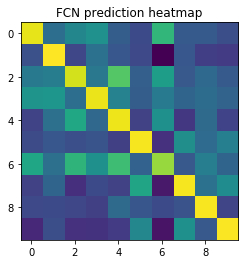

In [8]:
heatList = [[np.zeros((10,)), 0] for _ in range(10)]
for inputs, targets in testEpoches:
    predicts = test(inputs, True)
    predicts = predicts.cpu().detach().numpy()
    for predict, target in zip(predicts, targets):
        heatList[target][0] += predict
        heatList[target][1] += 1

for i, heat in enumerate(heatList):
    heatList[i][0] = heat[0] / heat[1]
heatMap = np.concatenate([heat[0][np.newaxis, :] for heat in heatList])
    
plt.imshow(heatMap, cmap='viridis', interpolation='nearest')
plt.title(f'FCN prediction heatmap')

## 总结
这次报告由于时间问题我没有在写爬虫程序爬取图片进行测试，在所给的测试集上达到了85%的准确率。
这次报告主要是使用PyTorch学习框架搭建了简单的FCN全连接网络，主要过程主要是网络模型的搭建。分类的准确率达到了80%以上。
对于图片的多分类任务，有很多可以使用的现成的网络模型，比如ResNet18，VGGNet等等，这些卷积神经网络由于卷积层的作用，在图片分类的效果要比简单的全连接网络好一些。